In [2]:
from qiskit import IBMQ, Aer, transpile, schedule as build_schedule
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilderNoEcho
from qiskit_nature.drivers import Molecule # containerises the molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem # as opposed to vibrational or protein problems
from qiskit_nature.converters.second_quantization import QubitConverter # map fermionic operators to qubits
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer # reduce problem size, work with electronic Hamiltonian
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import numpy as np
IBMQ.load_account()
provider = IBMQ.get_provider()
qcomp = provider.get_backend('ibmq_manila')

In [3]:
def HEA_naive(num_q, depth):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            circuit.cx(q, q + 1)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rz(params[counter], q)
            counter += 1
    return circuit, params

In [10]:
depth = 20
qubits = 4
circuit, _ = HEA_naive(qubits, depth)
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()
spsa = SPSA(100)
qi = QuantumInstance(Aer.get_backend('aer_simulator'))
vqe_circuit = VQE(ansatz=circuit, quantum_instance=qi, optimizer=spsa)

In [6]:
total_dist = 5
dist = 0.3
incr_early = 0.1
incr_late = 0.3

real_energies = []
vqe_energies = []
dists = []
while dist < total_dist:
    print(dist, total_dist)
    molecule = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', 
                                               driver_type=ElectronicStructureDriverType.PYSCF)
    transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3, 4])
    es_problem = ElectronicStructureProblem(driver, transformers=[transformer])
    second_q_ops = es_problem.second_q_ops()    

    if dist == 0.3:
        print(second_q_ops[0])
        print(qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles))
        print(es_problem.grouped_property)    
        print(es_problem.grouped_property_transformed)

    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    res = calc.solve(es_problem)
    real_energies.append(np.real(res.total_energies[0]))

    calc = GroundStateEigensolver(qubit_converter, vqe_circuit) #VQEClient()
    res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies[0]))
    
    dists.append(dist)
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

0.3 5
Fermionic Operator
register length=6, number terms=342
  -0.6036995203445001 * ( +_0 -_0 )
+ -0.03997534699735743 * ( +_0 -_1 )
+ -0.06062928819976243 * ( +_0 -_2 )
+ -0.03997534699735746 * ( +_1 -_0 )
+ -0.5052997654649987 * ( +_1 -_1 )
+ -0.04956738 ...
0.3506395847821875 * IIII
- 0.14909655185986742 * IIIZ
- 0.0021046083044148314 * IIZX
+ 0.0021046083044148314 * IIIX
+ 0.038372741994211854 * IIXX
- 0.03837274199421216 * IIYY
- 0.19067507919376378 * IIZZ
+ 0.005912533720255417 * IIXZ
+ 0.005912533720255499 * IIXI
+ 0.6524968507465327 * IIZI
+ 0.1490965518598678 * IZII
+ 0.002104608304414721 * ZXII
+ 0.0021046083044148007 * IXII
+ 0.03837274199421209 * XXII
- 0.0383727419942121 * YYII
- 0.19067507919376417 * ZZII
- 0.005912533720255563 * XZII
+ 0.005912533720255483 * XIII
- 0.6524968507465387 * ZIII
- 0.08033282251972478 * IZIZ
- 0.009993840959586171 * IZZX
+ 0.009993840959586171 * IZIX
+ 0.015157321115748397 * IZXX
- 0.015157321115748319 * IZYY
- 0.009993840959586171 * ZXIZ
- 0

0.4 5
0.5 5
0.6 5
0.7 5
0.7999999999999999 5
0.8999999999999999 5
0.9999999999999999 5
1.0999999999999999 5
1.2 5
1.3 5
1.4000000000000001 5
1.5000000000000002 5
1.6000000000000003 5
1.7000000000000004 5
1.8000000000000005 5
1.9000000000000006 5
2.0000000000000004 5
2.1000000000000005 5
2.2000000000000006 5
2.3000000000000007 5
2.400000000000001 5
2.500000000000001 5
2.8000000000000007 5
3.1000000000000005 5
3.4000000000000004 5
3.7 5
4.0 5
4.3 5
4.6 5
4.8999999999999995 5


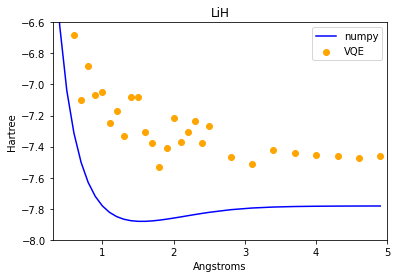

In [11]:
plt.plot(dists, real_energies, label='numpy', color='blue')
plt.scatter(dists, vqe_energies, label='VQE', color='orange')
plt.title("LiH")
plt.ylim(-8, -6.6)
plt.xlim(0.3, 5)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()